### Exercise 5 - Optimal Control Problem Formulations

In this exercise we will have a look at the special structures of the optimal control formulations discussed in the class. To this end, we will consider the control of a pendulum. 
The pendulum position is described by the angle $\theta$ with corresponding angle velocity $\omega$ and we can control it by applying a torque $\tau$. This system can be described by idealized dynamics
\begin{equation}\label{eq:dynamics}
\begin{aligned}
\dot{\theta} &= \omega, \\
\dot{\omega} &= \sin(\theta) + \tau,
\end{aligned}
\end{equation} 
where for simplicity we are ignoring all units. Defining the state $s=(\theta, \omega)$, with control actions $a=\tau$, our control aim is to swing up the pendulum to the upright position and balancing it there, corresponding to a state of $s_\mathrm{ref}=(0,0)$. We start with the pendulum hanging down in a rest position, i.e., $\bar s_0=(\pi,0)$.

We can express this as the discrete time optimal control problem 
<img src="imgs/nlp.png" alt="nlp" width="350"/>

with $Q = \mathbb{I} $, $Q_N = 10\cdot \mathbb{I} $, and $ R = 2$.
Here, $x_0,\ldots, x_N \in\mathbb{R}^{2}$, $u_0,\ldots, u_{N-1} \in\mathbb{R}$, and $F(s, a)$ describes the discretized dynamics obtained by applying the explicit RK4 integration scheme to the given continuous time dynamics. The objective expresses our desire to bring the state $s$ close to the origin, while using not too much control effort, as quantified by deviations of the control variable from 0.
We will consider different reformulations of this nonlinear optimization problem and analyze their structure.


In [17]:
import numpy as np
from utils import *
from plot_utils import *
import matplotlib.pyplot as plt
from casadi import SX, vertcat, horzcat, sin, hessian, nlpsol, DM, vertsplit, reshape, dot

# horizon
N = 50

# continuous dynamics
ns = 2
na = 1

theta = SX.sym('theta')
omega = SX.sym('omega')
a = SX.sym('a')

theta_dot = omega
omega_dot = sin(theta) + a

s = vertcat(theta, omega)
s_dot = vertcat(theta_dot, omega_dot)

# discrete dynamics
dt = 0.1
n_steps = 10
s_next = integrate_RK4(s, a, s_dot, dt, n_steps)

s0_bar = np.array([np.pi, 0])   # initial state

# integrator
F = Function('F', [s, a], [s_next])

# cost
stage_cost = Function('stage_cost', [s, a], [s.T @ s + a.T @ a])
terminal_cost = Function('terminal_cost', [s], [10 * s.T @ s])

### 5.1 Sequential approach

The state variables in the above optimal control problem can be eliminated by means of a forward simulation such that a more compact optimization problem is obtained,
	\begin{equation}\label{eq:nlp_seq}
	\begin{aligned}
	&\underset{A}{\min} && \Phi(A), \\
	\end{aligned} 
	\end{equation}
	with $A = (a_0, \ldots, a_{N-1})$.

Complete the followingd template to formulate $\Phi(A)$ and set up the above problem, where $F(s_i,a_i)$ is an RK4 integrator with 10~intermediate RK4 steps over a total integration time of $h=0.1$. Use $N=50$ for the discrete time horizon (such that the continuous time horizon is $T=5$) and $\bar{s}_0=(\pi,\,0)$ as initial state. 

Solve the problem using IPOPT and plot the state and control trajectories in two separate plots. Use $a_i = 0.1, \,\, i=0,...,N-1,$ as initial guess. 

Before solving the problem, compute the Hessian of $\Phi(A)$ for some non-zero $A$ and plot its sparsity pattern using the command `spy`.


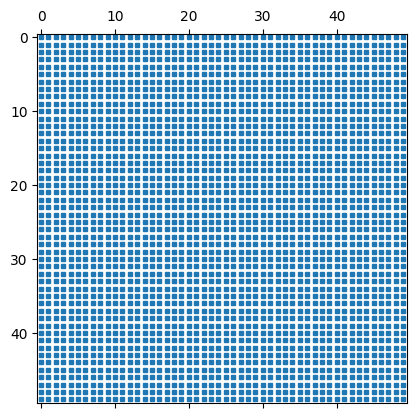

In [18]:
## NLP formulation
a_traj = SX.sym('a_traj', N)               # vector of all controls
a_traj_init = .1 * np.ones((N, 1))         # intial guess U

# build vector of all states dependend on U (only needed for plotting)
# should have shape (ns, N+1)
s_traj = [s0_bar]

s_current = s0_bar
cost = 0

for i in range(N):
    a_current = a_traj[i]
    cost += stage_cost(s_current, a_current)
    
    s_next = F(s_current, a_current)
    
    s_current = s_next
    
    s_traj.append(s_next) # only needed for plotting

# terminal cost
cost += terminal_cost(s_current)

s_traj = horzcat(*s_traj) # only needed for plotting

# plot sparsity pattern of the Hessian of the lagrangian
(hess, grad) = hessian(cost, a_traj)
hess_cost = Function('hess_cost', [a_traj], [hess])

plt.figure(1)
plt.spy(hess_cost(a_traj_init).full(), markersize=3)

In [4]:
# create nlp solver
nlp_seq = {'x': a_traj, 'f': cost}
solver_seq = nlpsol('solver','ipopt', nlp_seq)

# solve nlp
sol_seq = solver_seq(x0=a_traj_init)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1275

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

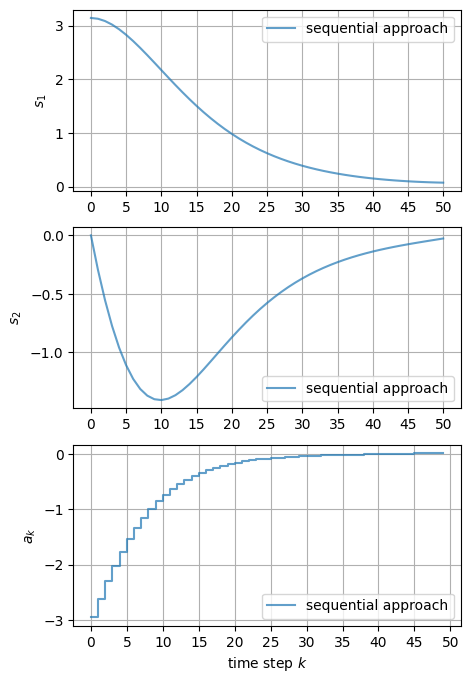

In [5]:
## visualize solution
a_traj_opt_seq = sol_seq['x'].full().T

F_s_traj = Function('F_s_traj', [a_traj], [s_traj])
s_traj_opt_seq = F_s_traj(a_traj_opt_seq).full()

plot_trajectories(s_traj_opt_seq, a_traj_opt_seq, 'sequential approach')

### 5.2 Simultaneous approach

If both states and controls are kept as decision variables, a larger problem is obtained with a special sparsity structure that can be exploited by tailored algorithms. 

Complete the following template to formulate the original optimal control problem without eliminating the state variables, solve it with IPOPT and plot the state and control trajectories. Make sure that you obtain the same result as with the sequential approach. 

Eliminate the initial state, by fixing it to $s_0 = \bar{s}_0$ and use $a_i = 0.1, \,\, i=0,...,N-1$ and $s_i = (0.1,0.1), \,\, i=1,...,N$ as initial guess.

efore solving the problem compute the Hessian of the Lagrangian and plot its sparsity pattern using the command `spy`. In order to highlight the block-banded structure of the Hessian, reorder the variables as $[a_0, \, \lambda_1, \, s_1,\,a_1,\lambda_2,\,... \,, \lambda_N, \, s_N,]$. For this last part, you can set the equality multipliers to any arbitrary non-zero value since we are only interested in the sparsity pattern here.
        

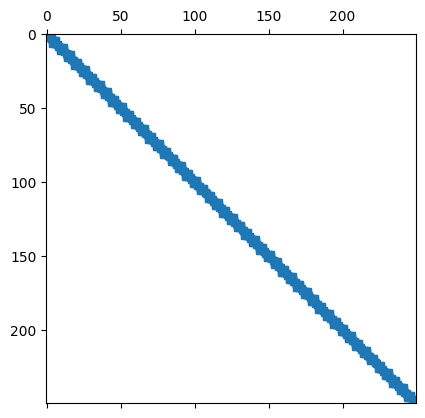

In [13]:
## NLP formulation

a_traj = SX.sym('a_traj', na*N)            # vector of all controls (0,..,N-1)
s_traj = SX.sym('s_traj', ns*N)            # vector of all states (1,..,N)

a_traj_init = .1 * np.ones((N, 1))         # intial guess
s_traj_init = .1 * np.ones((ns*N, 1))      # intial guess

lam_traj = SX.sym('lam_traj', ns*N)        # multiplier (1,..,N)

# build cost and constraints
s_current = s0_bar
constraints = []

cost = 0

s_traj_per_stage = vertsplit(s_traj, ns)
lam_traj_per_stage = vertsplit(lam_traj, ns)

z_traj = []

# note: you could use the casadi function map to construct the dynamic constraints
for i in range(N):
    a_current = a_traj[i]
    s_next    = s_traj_per_stage[i]    
    
    constraints.append(s_next - F(s_current, a_current))
    cost += stage_cost(s_current, a_current)
    
    # primal and dual variables in the required order 
    lam = lam_traj_per_stage[i]
    z_traj.extend([a_current, lam, s_next])

    s_current = s_next

# terminal cost
cost += terminal_cost(s_current)

constraints = vertcat(*constraints)
z_traj = vertcat(*z_traj)

# plot sparsity pattern of the Hessian of the lagrangian
lagrangian = cost + dot(lam_traj, constraints)

(hess, grad) = hessian(lagrangian, z_traj)
hess_lagrangian = Function('hess_lagrangian', [z_traj], [hess])

plt.figure(1)
plt.spy(hess_lagrangian(np.ones(z_traj.shape)).full(), markersize=3)

In [14]:
# create nlp solver
nlp_sim = {'x': vertcat(s_traj, a_traj), 'f': cost, 'g':constraints}
solver_sim = nlpsol('solver','ipopt', nlp_sim)

# solve nlp
lbg_ubg = np.zeros(constraints.shape)
sol_sim = solver_sim(x0=vertcat(s_traj_init, a_traj_init), lbg=lbg_ubg, ubg=lbg_ubg)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      396
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      297

Total number of variables............................:      150
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

(1, 150)


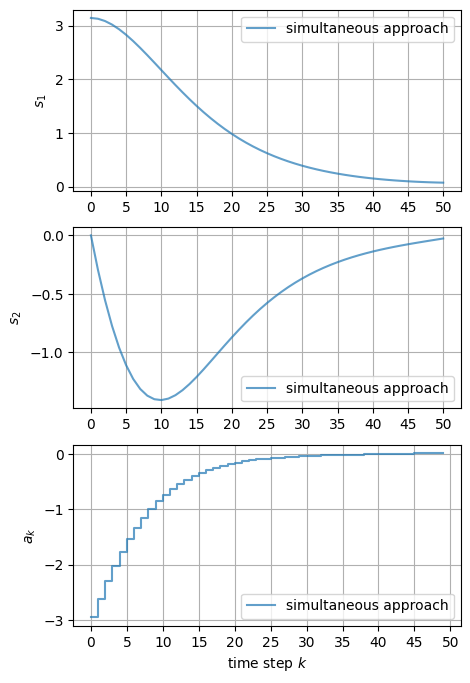

In [15]:
## visualize solution
s_a_traj_opt_sim = sol_sim['x'].full().T
print(s_a_traj_opt_sim.shape)
s_traj_opt_sim = reshape(vertcat(s0_bar, s_a_traj_opt_sim[:, :N*ns].T), (ns, N+1))
a_traj_opt_sim = s_a_traj_opt_sim[:, N*ns:]

plot_trajectories(s_traj_opt_sim, a_traj_opt_sim, 'simultaneous approach')

In [16]:
diff = np.max(np.abs(a_traj_opt_seq - a_traj_opt_sim))
print("difference in optimal control trajectories: %e" % (diff))

difference in optimal control trajectories: 7.865395e-10
